In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pprint import pprint

# Constants
SEED = 42
N_SIMULATIONS = 10_000
N_PARTICLES = 100
CONSENSUS_ITERATIONS = 50

# For reproducibility
np.random.seed(SEED)

# Exercise 1

We first define the system and all auxiliary matrices and vectors

In [2]:
# State space
nodes = ['o', 'a', 'b', 'c', 'd']
num_nodes = len(nodes)

# Transition rates matrix
Lambda = np.array([
            # o    a    b    c    d
            [0.0, 2/5, 1/5, 0.0, 0.0],  # o
            [0.0, 0.0, 3/4, 1/4, 0.0],  # a
            [1/2, 0.0, 0.0, 1/3, 0.0],  # b
            [0.0, 0.0, 1/3, 0.0, 2/3],  # c
            [0.0, 1/3, 0.0, 1/3, 0.0]   # d
        ])


# Degree vector
w = np.sum(Lambda, axis=1)
w_star = np.max(w)

# Transition probability matrix
P = np.zeros_like(Lambda)
for i in range(len(w)):
    if w[i] > 0:
        P[i, :] = Lambda[i, :] / w[i]

# Stationary distribution
vals, vecs = np.linalg.eig(P.T)
idx = np.argmin(np.abs(vals - 1))
pi = vecs[:, idx].real
pi = pi / np.sum(pi)

# Modified transition matrix P_bar
P_bar = Lambda/w_star 
P_bar = P_bar + np.diag(np.ones(len(w))-np.sum(P_bar,axis=1))

# Laplace-invariant probability distribution
values,vectors = np.linalg.eig(P_bar.T)
idx = np.argmax(values.real)
pi_bar = vectors[:, idx].real
pi_bar = pi_bar/np.sum(pi_bar)

print("Degree Vector:")
print(w)
print("\nTransition Probability Matrix:")
pprint(P)
print("\nStationary Distribution:")
pprint(pi)
print("\nModified Transition Matrix:")
pprint(P_bar)
print("\nLaplace-invariant probability distribution:")
pprint(pi_bar)

Degree Vector:
[0.6        1.         0.83333333 1.         0.66666667]

Transition Probability Matrix:
array([[0.        , 0.66666667, 0.33333333, 0.        , 0.        ],
       [0.        , 0.        , 0.75      , 0.25      , 0.        ],
       [0.6       , 0.        , 0.        , 0.4       , 0.        ],
       [0.        , 0.        , 0.33333333, 0.        , 0.66666667],
       [0.        , 0.5       , 0.        , 0.5       , 0.        ]])

Stationary Distribution:
array([0.16153846, 0.18461538, 0.26923077, 0.23076923, 0.15384615])

Modified Transition Matrix:
array([[0.4       , 0.4       , 0.2       , 0.        , 0.        ],
       [0.        , 0.        , 0.75      , 0.25      , 0.        ],
       [0.5       , 0.        , 0.16666667, 0.33333333, 0.        ],
       [0.        , 0.        , 0.33333333, 0.        , 0.66666667],
       [0.        , 0.33333333, 0.        , 0.33333333, 0.33333333]])

Laplace-invariant probability distribution:
array([0.2173913 , 0.14906832, 0.260

### (a) Average return time to a

In [3]:
def simulate_step(current_node, approach=2):
    if approach == 1:
        # Global clock
        dt = -np.log(np.random.rand()) / w_star
        # Transition using P_bar (includes self-loops)
        next_node = np.random.choice(num_nodes, p=P_bar[current_node, :])
        
    elif approach == 2:
        # Local clock
        dt = -np.log(np.random.rand()) / w[current_node]
        # Transition using P (no self-loops)
        next_node = np.random.choice(num_nodes, p=P[current_node, :])
        
    return next_node, dt

def get_return_time(start_node_idx, approach=2):
    current = start_node_idx
    total_time = 0
    
    # Force the first step to leave (or stay if using approach 1 self-loop)
    # For approach 2, we leave immediately. For approach 1, we might self-loop
    while current == start_node_idx:
        current, dt = simulate_step(current, approach)
    total_time += dt

    while current != start_node_idx:
        current, dt = simulate_step(current, approach)
        total_time += dt
        
    return total_time

def get_hitting_time(start_node_idx, target_node_idx, approach=2):
    current = start_node_idx
    total_time = 0

    # In this case there is no need to force to leave for approach 1
    # as we suppose the target is different from the start

    while current != target_node_idx:
        current, t = simulate_step(current, approach)
        total_time += t
        
    return total_time

#### Simulate with global clock
1st approach: global clock with rate $\omega_*$ and matrix $\bar{P}$

In [4]:
times_a = [get_return_time(1) for _ in range(N_SIMULATIONS)]
avg_return_a = np.mean(times_a)
print(f"Avg return time for node 'a': {avg_return_a:.2f} time units")

Avg return time for node 'a': 6.71 time units


#### Simulate with local clocks
2nd approach: local clocks with rates $\omega_i$ and matrix $P$

In [5]:
times_a = [get_return_time(1) for _ in range(N_SIMULATIONS)]
avg_return_a = np.mean(times_a)
print(f"Avg return time for node 'a': {avg_return_a:.2f} time units")

Avg return time for node 'a': 6.64 time units


### (b) Compute $\mathbb{E}_a[T^+_a]$

#### Option 1: Solving linear system
Can be done by either solve the linear system ...

In [6]:
def trivial_hitting_times_linear_system(target_node_idx):

    # Since nodes are few, we can directly build and solve the linear system
    n = len(nodes)
    A = np.zeros((n, n))
    b = np.zeros(n)
    
    for i in range(n):
        if i == target_node_idx:
            A[i, i] = 1
            b[i] = 0
        else:
            A[i, i] = -1
            for j in range(n):
                A[i, j] += P[i, j]
            b[i] = -1 / w[i]
    
    h_full = np.linalg.solve(A, b)

    return h_full

In [7]:
def hitting_times_linear_system(target_node_idx):
    # ! Remove later
    
    # Solution that exclused nodes in S (to avoid, too complex for few nodes)

    # ---

    # Notes we took in the call on derivation of the linear system
    # x_i = 1/omega_i + SUM_j Pij x_j
    # 0 = 1/omega_i + SUM_j(Pij x_j) - x_i
    # - 1/omega_i = SUM_j(Pij x_j) - x_i
    # SUM_j(Pij x_j) - x_i = - 1/omega_i

    # i = 0, j = 1, 2, 3, 4 with S = {5}
    # P01 x_1 + P02 x_2 + P03 x_3 + P04 x_4 - 1 * x_0 = - 1 / omega_0
    # 1 * x_0 - P01 x_1 - P02 x_2 - P03 x_3 - P04 x_4 = 1 / omega_0

    # P*x (in row i=0): [1, -P01, -P02, -P03, -P04] * [x_0, x_1, x_2, x_3, x_4] = 1 / omega_0
    # then for each row...

    # i = rows, j = columns
    # b_i = -1/omega_i

    # A x = b

    # ---

    # We need to solve for h_o, h_b, h_c, h_d. 
    # h_a is 0, so we exclude it from the system of unknowns
    non_target_indices = [i for i in range(len(nodes)) if i != target_node_idx]
    n_unknowns = len(non_target_indices)

    # We are building a system A_sys * h_vec = b_vec
    # Rearranging the equation: h_i - sum(P_ik * h_k) = 1/w_i
    A_sys = np.zeros((n_unknowns, n_unknowns))
    b_vec = np.zeros(n_unknowns)

    map_idx = {original: new for new, original in enumerate(non_target_indices)}

    for i, node_idx in enumerate(non_target_indices):
        # The equation for node_idx:
        # 1 * h_node_idx - sum(P_ik * h_k) = 1/w_node_idx
        
        # Diagonal element (h_node_idx)
        A_sys[i, i] = 1.0
        
        # Right hand side (holding time)
        b_vec[i] = 1.0 / w[node_idx]
        
        # Subtract neighbors' terms
        for neighbor_idx in range(len(nodes)):
            if neighbor_idx == target_node_idx:
                continue # h_a is 0, so P_ik * 0 = 0. No term to subtract.
            
            weight = P[node_idx, neighbor_idx]
            if weight > 0:
                # Find where this neighbor lives in our reduced system
                col_idx = map_idx[neighbor_idx]
                A_sys[i, col_idx] -= weight

    # Solve the linear system
    h_values_reduced = np.linalg.solve(A_sys, b_vec)

    # Map back to full array
    h_full = np.zeros(len(nodes))
    for i, original_idx in enumerate(non_target_indices):
        h_full[original_idx] = h_values_reduced[i]

    return h_full

In [8]:
# Solve for hitting times to 'a'
target_node_idx = 1  # 'a' is at index 1

# ! Remove non-trivial version later
h_full = hitting_times_linear_system(target_node_idx)

# Output results (all for debugging purposes)
print("Hitting times to 'a' from other nodes:")
for i, val in enumerate(h_full):
    if i != target_node_idx:
        print(f"  h_{nodes[i]} -> a : {val:.4f}")

# ! Keep this only
print("-" * 30)
trivial_h_full = trivial_hitting_times_linear_system(target_node_idx)
print("Trivial hitting times to 'a' from other nodes:")
for i, val in enumerate(trivial_h_full):
    if i != target_node_idx:
        print(f"  h_{nodes[i]} -> a : {val:.4f}")

# Convert hitting times to return time over a
# E[T_a+] = 1/w_a + sum(P_aj * h_j) (weighted average of neighbor hitting times)
rate_a = w[target_node_idx]
probs_a = P[target_node_idx]

avg_neighbor_hitting_time = np.sum(probs_a * trivial_h_full)
theoretical_return_a = (1.0 / rate_a) + avg_neighbor_hitting_time

print("-" * 30)
print(f"Return time E_a[T_a+]: {theoretical_return_a:.4f}")


Hitting times to 'a' from other nodes:
  h_o -> a : 3.5556
  h_b -> a : 5.6667
  h_c -> a : 5.8333
  h_d -> a : 4.4167
------------------------------
Trivial hitting times to 'a' from other nodes:
  h_o -> a : 3.5556
  h_b -> a : 5.6667
  h_c -> a : 5.8333
  h_d -> a : 4.4167
------------------------------
Return time E_a[T_a+]: 6.7083


#### Option 2: Use $\bar \pi$ theorem

Or leverage theorem ...

In [9]:
theoretical_return_a = 1/(pi_bar[1]*w[1])
print(f"Return time E_a[T_a+]: {theoretical_return_a:.4f} time units")

Return time E_a[T_a+]: 6.7083 time units


### (c) Average time to hit node d from node o 

#### Simulate with global clock
1st approach: global clock with rate $\omega_*$ and matrix $\bar{P}$

In [10]:
times_o = [get_hitting_time(0, 4, approach=1) for _ in range(N_SIMULATIONS)]
avg_hitting_o = np.mean(times_o)

print(f"Avg hitting time for node 'o': {avg_hitting_o:.2f} time units")

Avg hitting time for node 'o': 10.70 time units


#### Simulate with local clock

2nd approach: local clocks with rates $\omega_i$ and matrix $P$

In [11]:
times_o = [get_hitting_time(0, 4, approach=2) for _ in range(N_SIMULATIONS)]
avg_hitting_o = np.mean(times_o)

print(f"Avg hitting time for node 'o': {avg_hitting_o:.2f} time units")

Avg hitting time for node 'o': 10.70 time units


### (d) Compute $\mathbb{E}_o[T_d]$
We do not have theorem as in (b), we can only solve the linear system

In [12]:
start_node_idx = 0  # node 'o' is index 0
target_node_idx = 4  # node 'd' is index 4

# Same as before, but now we do not need to convert to return times
h_full = hitting_times_linear_system(target_node_idx)

# Output results (all for debugging purposes)
print("Hitting times to 'd' from other nodes:")
for i, val in enumerate(h_full):
    print(f"  h_{nodes[i]} -> d : {val:.4f}")

print("-" * 30)
trivial_h_full = trivial_hitting_times_linear_system(target_node_idx)
print("Trivial hitting times to 'a' from other nodes:")
for i, val in enumerate(trivial_h_full):
    if i != target_node_idx:
        print(f"  h_{nodes[i]} -> a : {val:.4f}")

print("-" * 30)
result = h_full[start_node_idx]
print(f"Hitting Time E[T_o -> d]: {result:.4f}")

Hitting times to 'd' from other nodes:
  h_o -> d : 10.7667
  h_a -> d : 9.0000
  h_b -> d : 9.3000
  h_c -> d : 4.1000
  h_d -> d : 0.0000
------------------------------
Trivial hitting times to 'a' from other nodes:
  h_o -> a : 10.7667
  h_a -> a : 9.0000
  h_b -> a : 9.3000
  h_c -> a : 4.1000
------------------------------
Hitting Time E[T_o -> d]: 10.7667


### (e) Simulate the French-DeGroot dynamics on $G=(V, \Epsilon, \Lambda)$ with an arbitrary initial condition $x(0)$

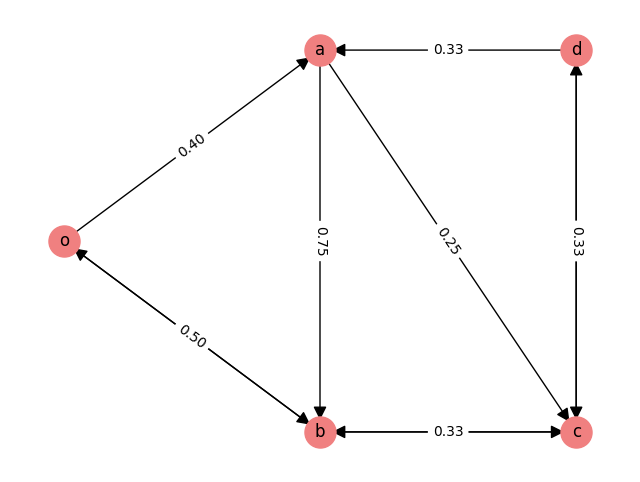

In [13]:
# Prepare graph
G = nx.DiGraph()
for i, origin in enumerate(nodes):
    for j, target in enumerate(nodes):
        weight = Lambda[i, j]
        if weight > 0:
            G.add_edge(origin, target, weight=weight, label=f"{weight:.2f}")

# Plotting
plt.figure(figsize=(8, 6))
pos = {
    'o': (0, 1),
    'a': (1, 2),
    'b': (1, 0),
    'd': (2, 2),
    'c': (2, 0)
}

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightcoral')
nx.draw_networkx_labels(G, pos)

# Draw edges
nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=20)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.axis('off')
plt.show()

The update rule of the node opinion is $x(t+1) = Px(t)$

In [14]:
consensus_values = []

for i in range(N_SIMULATIONS):
    x = np.random.uniform(0, 100, num_nodes)  # arbitrary initial condition x(0)

    # Simulation
    history = [x.copy()] # Store for the plot 
    for k in range(CONSENSUS_ITERATIONS):
        x = P @ x
        history.append(x.copy())
    if np.allclose(x, x[0]):
        consensus_values.append(True) # mark the arbitrary initial condition as converging
    else:
        consensus_values.append(False) # mark the arbitrary initial condition as not converging

if all(consensus_values):
    print(f"The dynamics converge to the consensus {history[-1].tolist()}")
else:
    print("The dynamics do not converge to consensus for all initial conditions")

The dynamics converge to the consensus [38.96173555776903, 38.96173491357327, 38.96173757452203, 38.96173242087087, 38.961738423825885]


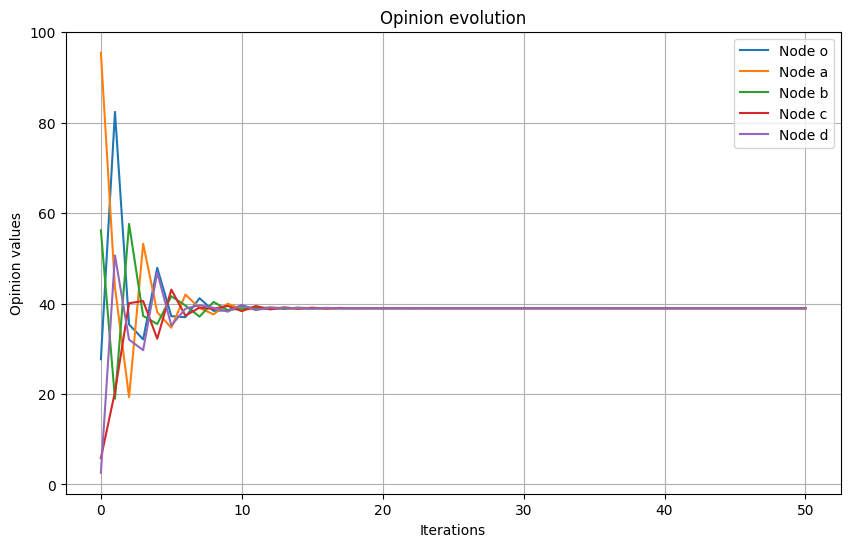

In [15]:
history = np.array(history)

# Plotting only one simulation run
plt.figure(figsize=(10, 6))
for i in range(num_nodes):
    plt.plot(history[:, i], label=f'Node {nodes[i]}')

plt.title("Opinion evolution")
plt.xlabel("Iterations")
plt.ylabel("Opinion values")
plt.legend()
plt.grid(True)
plt.show()

We can also check the convergence with the Theorem:  
$\quad$ if $G=(V,\Epsilon,W)$ possesses a globally reachable aperiodic component $C_0$, then $$\lim_{t\to + \infty}x_i(t)=\pi 'x(0) \: \forall i$$

In [16]:
is_strongly_connected = nx.is_strongly_connected(G)
print(f"1. Is Strongly Connected? {is_strongly_connected}")

is_aperiodic = nx.is_aperiodic(G)
print(f"2. Is Aperiodic? {is_aperiodic}")

1. Is Strongly Connected? True
2. Is Aperiodic? True


### (f) Compute the variance of the consensus value
Assume that the initial state of the dynamics for each node $i \in V$ is given by $x_i(0) = ξ_i$, where ${ξ_i} \; i\in V$ are independent random variables with variance $$ \sigma_a^2 = \sigma_b^2 = \sigma_a^2 = \sigma_c^2 = 2, \; \sigma_o^2 = \sigma_d^2 = 1$$  

In [17]:
# Define variances
sigmas_sq = np.array([1.0, 2.0, 2.0, 2.0, 1.0]) 
sigmas = np.sqrt(sigmas_sq)

# Theoretical computation
theoretical_var = np.sum((pi**2) * sigmas_sq)
print(f"Theoretical Variance: {theoretical_var:.5f}")

Theoretical Variance: 0.36941


In [18]:
# Simulation
consensus_values = []
for i in range(N_SIMULATIONS):
    x = np.random.normal(0, sigmas, num_nodes)
    if i==0:
        x0 = x
    for n in range(CONSENSUS_ITERATIONS):
        x = P @ x
        
    consensus_values.append(x)

consensus_values = np.array(consensus_values)
empirical_var = np.var(consensus_values, axis=0) # Get variance per node, they shall be all the same

print(f"Empirical Variance:{empirical_var}")

Empirical Variance:[0.37431093 0.37431093 0.37431092 0.37431094 0.37431092]


## (g)

In [19]:
...

Ellipsis

## (h)

In [20]:
...

Ellipsis

# Exercise 2

In [21]:
# ! Move at start if Exercise 1, once removed the non-trivial lin.sys. resolver
node_idx = {n: i for i, n in enumerate(nodes)}

## (a) Particle perspective simulation

In [22]:
def simulate_particles_return_time_local_clock(start_node_idx, n_particles):

    return_times = []

    # Since particles do not interact, we can simulate them independently, statistically the results will be the same
    for _ in range(n_particles):
        current_node = start_node_idx
        time_elapsed = 0.0
        
        while True:
            # Local clock
            rate = w[current_node]
            dt = -np.log(np.random.rand()) / rate
            time_elapsed += dt
            
            next_node = np.random.choice(num_nodes, p=P[current_node]) # Local jump matrix
            
            current_node = next_node
            
            if current_node == start_node_idx:
                return_times.append(time_elapsed)
                break
                
    return np.array(return_times)

def simulate_particles_return_time_global_clock(start_node_idx, n_particles):
    
    # Positions of all particles
    positions = np.full(n_particles, start_node_idx, dtype=int)
    
    # Flags the particle has left the starting node
    has_left = np.full(n_particles, False, dtype=bool)
    
    # Flags the particle has returned
    finished = np.full(n_particles, False, dtype=bool)
    
    # Return times for each particle
    return_times = np.zeros(n_particles)
    
    # Global rate and time and particle counters
    global_rate = n_particles * w_star
    current_time = 0.0
    count_finished = 0
    
    while count_finished < n_particles:
        
        # Advance global clock
        dt = -np.log(np.random.rand()) / global_rate
        current_time += dt
        
        # Randomly select a particle to move
        # Since we use a fixed rate global clock, a particle could be selected even if it has finished
        p_idx = np.random.randint(0, n_particles)
        
        # Get current position of the selected particle
        curr_node_idx = positions[p_idx]
        
        # Select next node to jump on, based on jump matrix P
        next_node_idx = np.random.choice(num_nodes, p=P_bar[curr_node_idx])
        
        if not finished[p_idx]:
            
            # Check if particle has left (no self-jump)
            if curr_node_idx == start_node_idx and next_node_idx != start_node_idx:
                has_left[p_idx] = True
            
            # Check if returned to start and has left (avoid immediate return on self-loop)
            if next_node_idx == start_node_idx and has_left[p_idx]:
                return_times[p_idx] = current_time
                finished[p_idx] = True
                count_finished += 1
        
        # Update position
        positions[p_idx] = next_node_idx

    return return_times

### Simulate with local clock

In [23]:
# We smooth the results by running multiple times
return_times = np.concatenate([simulate_particles_return_time_local_clock(node_idx['a'], N_PARTICLES) for _ in range(N_SIMULATIONS // 10)])
avg_return_time = np.mean(return_times)

print(f"Average return time simulated: {avg_return_time:.4f}")
print(f"Comparison with theoretical: {theoretical_return_a:.4f}")

Average return time simulated: 6.7150
Comparison with theoretical: 6.7083


### Simulate with global clock

In [24]:
# We smooth the results by running multiple times
return_times = np.concatenate([simulate_particles_return_time_global_clock(node_idx['a'], N_PARTICLES) for _ in range(N_SIMULATIONS // 100)])
avg_return_time = np.mean(return_times)

print(f"Average return time simulated: {avg_return_time:.4f}")
print(f"Comparison with theoretical: {theoretical_return_a:.4f}")

Average return time simulated: 6.7286
Comparison with theoretical: 6.7083


## (b) Node perspective simulation

In [25]:
def simulate_node_perspective_with_global_clock(start_dist, max_time):

    # Prepare time and particle counts (given initial distribution of particles)
    counts = np.array(start_dist, dtype=int)
    n_particles = np.sum(counts)
    current_time = 0.0
    
    # Needed for plotting later
    times = [current_time]
    history = [counts.copy()]

    # Calculate total system rate
    total_system_rate = n_particles * w_star
    
    # Main simulation loop
    while True:
            
        # Time to next event (global clock)
        dt = -np.log(np.random.rand()) / total_system_rate
        current_time += dt
        
        if current_time > max_time:
            break
        
        # Use current distribution of particles over the noes to choose which node moves a particle
        source_node = np.random.choice(num_nodes, p=counts/n_particles)
        
        # Use P_bar to choose where the particle jumps
        target_node = np.random.choice(num_nodes, p=P_bar[source_node])
    
        # Update states (decrease source, increase target)
        counts[source_node] -= 1
        counts[target_node] += 1
        
        # Store for plotting later
        times.append(current_time)
        history.append(counts.copy())
    
    return np.array(times), np.array(history)

In [26]:
def simulate_node_perspective_with_local_clock(start_dist, total_time):
    # Prepare time and particle counts (given initial distribution of particles)
    counts = np.array(start_dist, dtype=int)
    current_time = 0.0

    # For plotting later
    times = [0.0]
    history = [counts.copy()]
    
    while True:
        # Local Clocks: each node proposes a waiting time (dt) based on its current number of particles and rate
        
        # If node is empty, time is infinite
        proposed_delays = np.full(num_nodes, np.inf)
        
        # rate_i = n_i * omega_i
        current_rates = counts * w
        
        for i in range(num_nodes):
            if current_rates[i] > 0:
                # exponential local time for node i
                # proposed_delays[i] = np.random.exponential(1.0 / current_rates[i])
                proposed_delays[i] = -np.log(np.random.rand()) / current_rates[i]
        
        # Quickiest node move one of its particles
        min_delay = np.min(proposed_delays)
        if min_delay == np.inf: # Edge case: all nodes empty (system is stuck)
            break
        
        # Increase global time
        current_time += min_delay
        if current_time > total_time: # If we exceed total time, we stop
            break
            
        # Extract source and target nodes
        source_node = np.argmin(proposed_delays)
        target_node = np.random.choice(num_nodes, p=P[source_node])
        
        # Update states (decrease source, increase target)
        counts[source_node] -= 1
        counts[target_node] += 1
        
        # Store for plotting later
        times.append(current_time)
        history.append(counts.copy())
        
    return np.array(times), np.array(history)

### Simulate with global clock

In [27]:
initial_counts = [0, N_PARTICLES, 0, 0, 0] # every particle starts in 'a'
T_max = 60
times, history = simulate_node_perspective_with_global_clock(initial_counts, T_max)

# Get final counts and expected counts
final_counts = history[-1].tolist()
final_time = times[-1]
events_count = len(times)

print(f"Total time unit for the whole simulation: {T_max}:")
print(f"\t> {final_time:.4f} final time recorded")
print(f"\t> {events_count} time steps recorded")

print("-"*30)
print(f"Simulated final counts global fixed clock")
print(dict(zip(nodes, final_counts)))

# Use stationary distribution that account for times also. pi_bar means percentage of particles at each node at stationarity
expected_counts = (pi_bar * N_PARTICLES).round().tolist()
print("Theoretical stationary expected counts (N * pi_bar):")
print(dict(zip(nodes, expected_counts)))

Total time unit for the whole simulation: 60:
	> 59.9984 final time recorded
	> 6006 time steps recorded
------------------------------
Simulated final counts global fixed clock
{'o': 24, 'a': 10, 'b': 31, 'c': 17, 'd': 18}
Theoretical stationary expected counts (N * pi_bar):
{'o': 22.0, 'a': 15.0, 'b': 26.0, 'c': 19.0, 'd': 19.0}


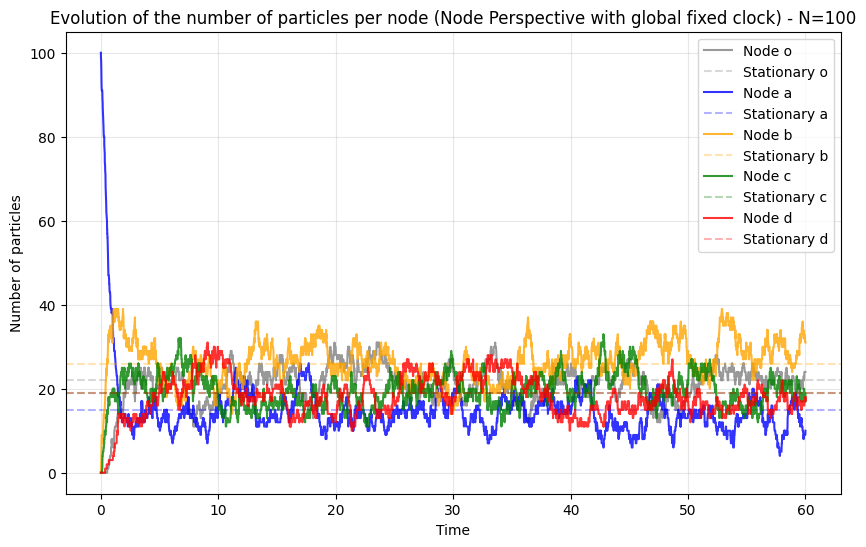

In [28]:
# Plotting
history_arr = np.array(history)

plt.figure(figsize=(10, 6))
colors = ['gray', 'blue', 'orange', 'green', 'red']
for i in range(num_nodes):
    plt.plot(times, history[:, i], label=f'Node {nodes[i]}', color=colors[i], alpha=0.8)
    plt.axhline(y=expected_counts[i], color=colors[i], linestyle='--', alpha=0.3, label=f'Stationary {nodes[i]}')

plt.title(f'Evolution of the number of particles per node (Node Perspective with global fixed clock) - N={sum(initial_counts)}')
plt.xlabel('Time')
plt.ylabel('Number of particles')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.savefig('node_perspective_simulation_global_clock.png')
plt.show()

### Simulate with local clocks

In [29]:
initial_counts = [0, N_PARTICLES, 0, 0, 0] # Every particle starts in 'a'
T_max = 60
times, history = simulate_node_perspective_with_local_clock(initial_counts, T_max)

# Get final counts and expected counts
final_counts = history[-1].tolist()
final_time = times[-1]
events_count = len(times)

print(f"Total time unit for the whole simulation: {T_max}:")
print(f"\t> {final_time:.4f} final time recorded")
print(f"\t> {events_count} time steps recorded")

print("-"*30)
print(f"Simulated final counts local clocks")
print(dict(zip(nodes, final_counts)))

# Use stationary distribution that account for times also. pi_bar means percentage of particles at each node at stationarity
expected_counts = (pi_bar * N_PARTICLES).round().tolist()
print("Theoretical stationary expected counts (N * pi_bar):")
print(dict(zip(nodes, expected_counts)))

Total time unit for the whole simulation: 60:
	> 59.9890 final time recorded
	> 4872 time steps recorded
------------------------------
Simulated final counts local clocks
{'o': 21, 'a': 7, 'b': 26, 'c': 19, 'd': 27}
Theoretical stationary expected counts (N * pi_bar):
{'o': 22.0, 'a': 15.0, 'b': 26.0, 'c': 19.0, 'd': 19.0}


Time Average Counts
{'o': np.float64(20.0), 'a': np.float64(15.0), 'b': np.float64(27.0), 'c': np.float64(20.0), 'd': np.float64(19.0)}


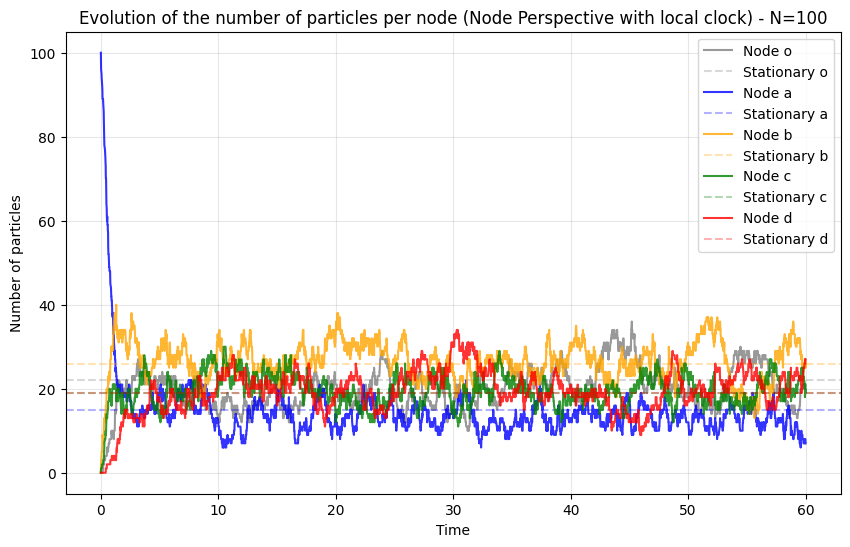

In [30]:
# Plotting
history_arr = np.array(history)

# Time average count (without initial transient)
time_averaged_counts = np.mean(history_arr[10:], axis=0) # Discard first 10 steps of transient

print("Time Average Counts")
print(dict(zip(nodes, np.round(time_averaged_counts, 0))))

plt.figure(figsize=(10, 6))
colors = ['gray', 'blue', 'orange', 'green', 'red']
for i in range(num_nodes):
    plt.plot(times, history[:, i], label=f'Node {nodes[i]}', color=colors[i], alpha=0.8)
    plt.axhline(y=expected_counts[i], color=colors[i], linestyle='--', alpha=0.3, label=f'Stationary {nodes[i]}')

plt.title(f'Evolution of the number of particles per node (Node Perspective with local clock) - N={sum(initial_counts)}')
plt.xlabel('Time')
plt.ylabel('Number of particles')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.savefig('node_perspective_simulation_local_clock.png')
plt.show()